### ML4Science: BERT: Prediction of EL222 protein conformation based on amino acid sequences.  

This is a Notebook for evaluation of a BERT model and corresponding classifier. It is intended for running on Google Colab, since the first part requires GPUs for faster execution. In order to run it, you should put provided folders, utils and data in the owning Google Drive and then just run the script.

Install necessary libraries, that are not present in the Google Colab already.

In [1]:
!pip install torchmetrics
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.6 MB/s eta 0:00:00


Mount Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, SubsetRandomSampler
import pandas as pd
import random
import numpy as np
from torchmetrics.classification import BinaryF1Score
import sys
import matplotlib.pyplot as plt

sys.path.append("/content/gdrive/My Drive/")
import ipywidgets as widgets
from types import SimpleNamespace
from utils import data, evaluation, models

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

import math

from transformers import logging

In [4]:
# Set seeds
seed = 128
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cuda


Set all the parameters necessary for the BERT model, as well as the data for training.

In [5]:
from weakref import ProxyType
kmer = 2
mask_length = kmer
vocab = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", "M", "F", "S", "P", "T", "W", "Y", "V", "-"]
VOCAB_1MER = ["[PAD]", "[UNK]", "[CLS]", "[SEP]"] + data.make_2aa_comb(vocab)

raw_training_data = data.load_csv("/content/gdrive/My Drive/data/all_train.csv")
raw_test_data = data.load_csv("/content/gdrive/My Drive/data/all_test.csv")
dataset_train_size = len(raw_training_data)
dataset_test_size = len(raw_test_data)
prot_max_len = 153
batch_size = 512
max_prot_mask = 50
num_layers = 3
num_heads = 6
prot_config = SimpleNamespace(
        vocab_size=len(VOCAB_1MER),
        hidden_size=120,
        max_position_embeddings=prot_max_len,
        type_vocab_size=1,
        layer_norm_eps=1e-12,
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.0,
        num_attention_heads=num_heads,
        hidden_act="gelu",
        intermediate_size=160,
        num_hidden_layers=num_layers,
        is_decoder=False,
        output_attentions=True,
        output_hidden_states=True,
        pruned_heads = {},
        initializer_range=0.02,
        device=device
    )

In [6]:
tokenizer = data.Tokenizer(k=kmer, vocab=VOCAB_1MER)
input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks = data.generate_masked_data(raw_training_data, tokenizer, max_len=prot_max_len, max_mask=max_prot_mask, k=mask_length, mask_rate=0.05, max_size=dataset_train_size)
test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks = data.generate_masked_data(raw_test_data, tokenizer, max_len=prot_max_len, max_mask=max_prot_mask, k=mask_length, mask_rate=0.05, max_size=dataset_test_size)
model = models.BertForMaskedLM(config=prot_config, positional_embedding=models.PositionalEmbedding, attention=models.BertSelfAttention).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
print(f"Number of trainable model parameters: {models.number_of_model_parameters(model)}")

train_dataset = TensorDataset(input_ids, segment_ids, masked_lm_labels, labels_idx, labels, attention_masks)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_input_ids, test_segment_ids, test_masked_lm_labels, test_labels_idx, test_labels, test_attention_masks)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Number of trainable model parameters: 427525


Train BERT model on auxiliary task.

In [7]:
for epoch in range(150):

  total_train_loss = 0
  model.train()

  for batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask in train_loader:

    optimizer.zero_grad()

    # Get output of the model
    loss, outputs, hidden_states, _ = model(
        input_ids=batch_input_ids.to(device),
        token_type_ids=batch_segment_ids.to(device),
        masked_lm_labels=batch_masked_lm_labels.to(device),
        attention_mask=batch_attention_mask.to(device)
    )

    loss.backward()
    optimizer.step()
    total_train_loss += loss.item()

  # Average obtained loss
  avg_train_loss = total_train_loss / len(train_loader)

  # Do evaluation every 10 training epochs
  if (epoch + 1) % 10 == 0:

    model.eval()
    total_eval_loss = 0

    for batch_input_ids, batch_segment_ids, batch_masked_lm_labels, _, _, batch_attention_mask in test_loader:
      with torch.no_grad():

        loss, outputs, hidden_states, _ = model(
          input_ids=batch_input_ids.to(device),
          token_type_ids=batch_segment_ids.to(device),
          masked_lm_labels=batch_masked_lm_labels.to(device),
          attention_mask=batch_attention_mask.to(device)
        )

        if batch_attention_mask.sum() - torch.numel(batch_attention_mask) > 0 :
          print("found patting", batch_attention_mask.sum())

        total_eval_loss += loss.item()

    avg_eval_loss = total_eval_loss / len(test_loader)
    print('Epoch:', '%04d' % (epoch + 1), 'train cost =', '{:.6f}'.format(avg_train_loss), 'eval cost =', '{:.6f}'.format(avg_eval_loss))

# Print obtaned accuracies
average_train_acc, _ = evaluation.model_masked_label_accuracy(model, train_loader, device)
average_test_acc, last_test_attention = evaluation.model_masked_label_accuracy(model, test_loader, device)
print('Train Acc =', '{:.6f}'.format(average_train_acc), 'Eval Acc =', '{:.6f}'.format(average_test_acc))

Epoch: 0010 train cost = 3.801566 eval cost = 3.814154
Epoch: 0020 train cost = 3.330490 eval cost = 3.422602
Epoch: 0030 train cost = 3.113935 eval cost = 3.264568
Epoch: 0040 train cost = 2.942203 eval cost = 3.165613
Epoch: 0050 train cost = 2.774781 eval cost = 3.090015
Epoch: 0060 train cost = 2.602838 eval cost = 2.992952
Epoch: 0070 train cost = 2.403016 eval cost = 2.927864
Epoch: 0080 train cost = 2.201657 eval cost = 2.871229
Epoch: 0090 train cost = 1.986781 eval cost = 2.775978
Epoch: 0100 train cost = 1.752478 eval cost = 2.658372
Epoch: 0110 train cost = 1.519545 eval cost = 2.550620
Epoch: 0120 train cost = 1.300979 eval cost = 2.475284
Epoch: 0130 train cost = 1.108724 eval cost = 2.422105
Epoch: 0140 train cost = 0.942551 eval cost = 2.403046
Epoch: 0150 train cost = 0.815374 eval cost = 2.418616
Train Acc = 0.844767 Eval Acc = 0.530390


Here the work is done for the auxiliary task. Now we should train implemented classifier, which is fully-connected neural network.

In [8]:
# Load all the necessary data make data loader
on_sequences_path = "/content/gdrive/My Drive/data/all_on_sequences_v2.txt"
off_sequences_path = "/content/gdrive/My Drive/data/all_off_sequences_v2.txt"
raw_training_data, raw_test_data = data.balance_data(off_sequences_path, on_sequences_path, balance=True)
dataset, train_dataset, test_dataset = data.create_datasets(raw_training_data, raw_test_data, tokenizer, dna_max_len, mask_length, max_dna_mask, task="classifier")

Classifier on top of the BERT model.

In [115]:
# Define the classifier - linear layers
# define the binary classifier

class SequenceClassifier(nn.Module):
  """
  We use model pretraied on auxiliary task for classification.
  """
  def __init__(self, model, hidden_layers=[512, 256, 128, 64, 32], output_dim=1, dropout=0.0, activation=nn.ReLU()):
    """
    Initialize the classifier.

    Args:
      model (nn.Module): A pre-trained model.
      hidden_layers (list): Sizes of the layers.
      output_dim (int): Since we are doing classification, output_dim is 1.
      activation (callable): The activation function to apply after each hidden layer.
    """
    super(SequenceClassifier, self).__init__()

    # Use the pretrained model
    self.model = model

    # Create ModuleList with all the layers
    self.layer_sizes = [model.config.hidden_size] + hidden_layers + [output_dim]
    self.layers = nn.ModuleList()
    self.dropout = dropout
    self.activation = activation
    self.sigmoid = nn.Sigmoid()

    # Create hidden layers
    for i in range(len(self.layer_sizes)-1):
      self.layers.append(nn.Linear(self.layer_sizes[i], self.layer_sizes[i+1]))
      if i < (len(self.layer_sizes)-2): # No dropout or activation on the last layer
        self.layers.append(nn.Dropout(dropout))
        self.layers.append(activation)

  def forward(self, input_ids):
    """
    We do forward pass on the new model with classification head.

    Args:
      input_ids (torch.Tensor): Inputs necessary for auxiliary task for pretraining.

    Returns:
      output (torch.Tensor): Output from last classification layer.
    """
    _, hidden_states, _ = self.model(input_ids=input_ids)

    last_hidden_state = hidden_states[-1]

    out = last_hidden_state[:, 0, :] # the first token is the CLS token
    for layer in self.layers[:-1]:
      out = self.activation(layer(out))
      out = F.dropout(out, p=self.dropout, training=self.training) # If the model is in evaluation mode, no dropout will be applied

    out = self.layers[-1](out)

    return self.sigmoid(out)

In [116]:
# Freeze BERT parameters
for param in model.parameters():
  param.requires_grad = False

criterion = nn.BCELoss()

# Define parameters for cross-validation
mode = "other"
num_epochs = 250
k_folds = 5
splits = KFold(n_splits=k_folds, shuffle=True, random_state=42)
history = {'train_loss': [], 'test_loss': []}
batch_size = 16

Define the function that is going to represent one training epoch.

In [117]:
# Function for calculating the accuracy
def classification_accuracy(model, data_loader, device):
    correct_predictions = 0
    total_count = 0
    for input_ids, labels in data_loader:
        with torch.no_grad():
            input_ids = input_ids.to(device)
            labels = labels.float().unsqueeze(dim=1).to(device)

            logits = model(input_ids)

            preds = (logits > 0.5).float()
            correct_predictions += (preds == labels).sum().item()
            total_count += len(labels)

    accuracy = correct_predictions / total_count

    return accuracy

One train epoch.

In [118]:
def train_epoch(classifier, device, dataloader, criterion, optimizer):
  """
  Trains the model for one epoch.

  Args:
    classifier (nn.Module): Model we are training.
    device ("cpu" or "cuda"): Device at which we are doing training.
    dataloader (torch.DataLoader): Dataset data-loader.
    criterion (callable): Loss function use for training.
    optimizer (torch.optim): Optimizer used for training.

  Returns:
    train_loss (float): Train loss over all batches.

  """
  # Set model into train mode
  train_loss = 0.0
  for input_ids, class_labels in dataloader:
    input_ids = input_ids.to(device)
    class_labels = class_labels.float().unsqueeze(dim=1).to(device)

    # Reset gradients of all tracked variables
    optimizer.zero_grad()
    logits = classifier(input_ids)
    loss = criterion(logits, class_labels)

    # Calculate the loss for model outputs
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  return train_loss / len(dataloader)

Validation epoch.

In [119]:
def valid_epoch(classifier, device, dataloader, criterion):
  """
  Evaluate one epoch of trained model.

  Args:
    model (nn.Module): Model we are training.
    device ("cpu" or "cuda"): Device at which we are doing training.
    dataloader (torch.DataLoader): Dataset data-loader.
    criterion (callable): Loss function use for training.

  Returns:
    valid_loss (float): Validation loss over all batches.
  """

  # Set the model to evaluation mode
  valid_loss = 0.0
  classifier.eval()

  for input_ids, class_labels in dataloader:
    with torch.no_grad():

      input_ids = input_ids.to(device)
      class_labels = class_labels.float().unsqueeze(dim=1).to(device)

      # Make predictions
      logits = classifier(input_ids)
      loss = criterion(logits, class_labels)
      valid_loss += loss.item()

  return valid_loss / len(dataloader)

Cross-validation for the one specified set of hyperparameters (those are the best one that hyperparameter tuning from run.py yielded).

Fold: 0001
Epoch: 0001 train cost = 0.694664 val cost = 0.698864
Epoch: 0011 train cost = 0.692559 val cost = 0.697071
Epoch: 0021 train cost = 0.687965 val cost = 0.693924
Epoch: 0031 train cost = 0.681828 val cost = 0.689534
Epoch: 0041 train cost = 0.669974 val cost = 0.681040
Epoch: 0051 train cost = 0.649391 val cost = 0.664749
Epoch: 0061 train cost = 0.607586 val cost = 0.635728
Epoch: 0071 train cost = 0.544685 val cost = 0.596412
Epoch: 0081 train cost = 0.489137 val cost = 0.552522
Epoch: 0091 train cost = 0.435561 val cost = 0.522556
Epoch: 0101 train cost = 0.424307 val cost = 0.489822
Epoch: 0111 train cost = 0.395503 val cost = 0.486000
Epoch: 0121 train cost = 0.395771 val cost = 0.480801
Epoch: 0131 train cost = 0.384214 val cost = 0.480960
Epoch: 0141 train cost = 0.402241 val cost = 0.489688
Epoch: 0151 train cost = 0.395099 val cost = 0.462413
Epoch: 0161 train cost = 0.361684 val cost = 0.452715
Epoch: 0171 train cost = 0.377393 val cost = 0.445894
Epoch: 0181 train

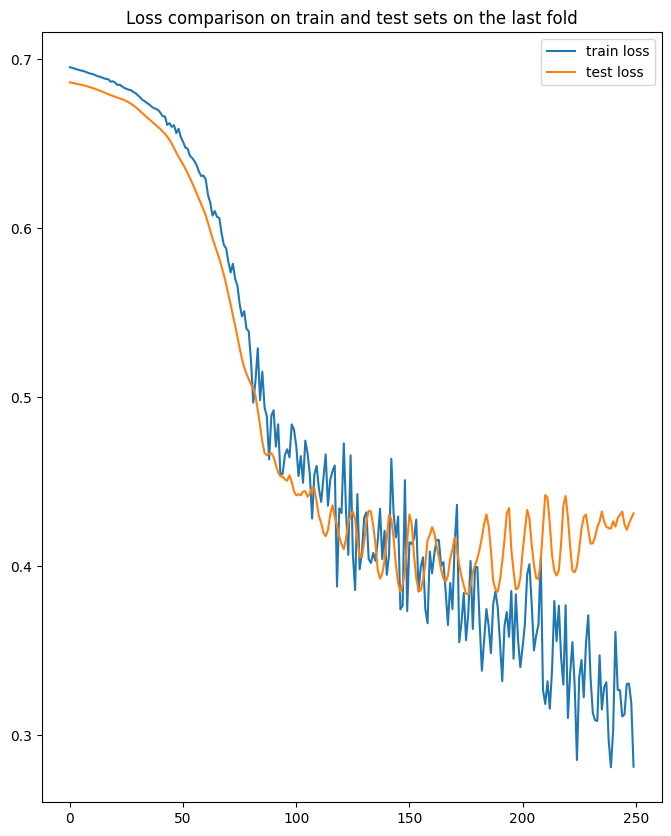

0.819047619047619


In [120]:
avg_test_acc = 0.0
torch.manual_seed(42)
for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

  print('Fold:', '%04d' % (fold + 1))
  # Generate train and test splits for this fold
  train_samples = SubsetRandomSampler(train_idx)
  test_samples = SubsetRandomSampler(val_idx)

  # Create DataLoaders for the samples
  train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_samples)
  test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_samples)

  # Here you can set specific parameters of the model
  classifier = SequenceClassifier(model).to(device)
  optimizer = optim.AdamW(classifier.parameters(), lr=0.0001, weight_decay=0.004)

  for epoch in range(num_epochs):
    classifier.train()
    train_loss = train_epoch(classifier, device, train_loader, criterion, optimizer)
    test_loss = valid_epoch(classifier, device, test_loader, criterion)
    if epoch % 10 == 0:
      print('Epoch:', '%04d' % (epoch + 1), 'train cost =', '{:.6f}'.format(train_loss), 'val cost =', '{:.6f}'.format(test_loss))

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)

  # Take accuracy of last epoch as a final accuracy of a fold
  avg_test_acc += classification_accuracy(classifier, test_loader, device)

  # Plot the train and test accuracy
  # Plot the train and test loss if this is specified only for the last fold
  if mode != "hyperparameter_tuning" and fold == k_folds - 1:
    plt.figure(figsize=(8, 10))
    # Loss subplot
    plt.plot(np.arange(num_epochs), history['train_loss'], label='train loss')
    plt.plot(np.arange(num_epochs), history['test_loss'], label='test loss')
    plt.title("Loss comparison on train and test sets on the last fold")
    plt.legend()
    plt.show()

  history['train_loss'].clear()
  history['test_loss'].clear()

test_acc_results = avg_test_acc / k_folds
print(test_acc_results)
